### Importing of modules and packages

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

### Assigning current 'Weekly-covid-admissions-and-bed-publication' to the variable 'current_covid_admissions' so data be updated weekly as new versions becomes available

In [12]:
current_covid_admissions ='/Users/ivan/Desktop/PycharmProjects/Data_Science_Mini/Data/raw/Weekly-covid-admissions-and-beds-publication-201224'

### Extracting last date from 'All beds COVID' sheet (any sheet could have been used) and assigning it to variable last_day

In [13]:
df = pd.read_excel(r'%s.xlsx' % current_covid_admissions,
                   sheet_name='All beds COVID',
                   engine='openpyxl')
last_index = df.iloc[13].last_valid_index()

# convert datetime to date in format
last_day = df.iloc[13][last_index].strftime('%m/%d/%Y')

## Function to read in summary data from 'All beds COVID' and 'MV beds COVID' sheets (7 rows from lines 18 to 24 of Excel sheet). Also converts headings to dates

In [14]:
list_of_regions = ['East of England','London', 'Midlands','North East and Yorkshire',
                   'North West', 'South East', 'South West','ENGLAND']
columns_to_drop = ['Type 1 Acute?', 'NHS England Region', 'Code']
datelist = pd.date_range(start='08/01/2020', end=last_day).strftime('%d-%m-%Y')


def new_summary_sheet(sheet_name):
    dataframe = sheet_name
    dataframe = pd.read_excel(r'%s.xlsx' % current_covid_admissions,
                            sheet_name=sheet_name,
                            header=14,
                            engine='openpyxl')
    dataframe = dataframe.loc[dataframe['Name'].isin(list_of_regions)]
    dataframe = dataframe.drop(columns=columns_to_drop)
    dataframe = dataframe.reset_index(drop=True)

    i = 0
    for col in dataframe.columns[1:len(datelist)+2]:
        dataframe.rename(columns={col:datelist[i]}, inplace=True)
        i += 1
    return dataframe


df_all_beds = new_summary_sheet('All beds COVID')
df_MV = new_summary_sheet('MV beds COVID')
df_MV.describe().round(1)

,01-08-2020,02-08-2020,03-08-2020,04-08-2020,05-08-2020,06-08-2020,07-08-2020,08-08-2020,09-08-2020,10-08-2020,...,13-12-2020,14-12-2020,15-12-2020,16-12-2020,17-12-2020,18-12-2020,19-12-2020,20-12-2020,21-12-2020,22-12-2020
count,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
mean,18.5,18.0,16.8,16.2,15.8,15.2,14.2,13.8,14.0,15.0,...,280.8,281.8,289.8,290.8,297.0,297.5,309.8,316.8,331.8,334.8
std,23.0,22.4,20.9,20.2,19.6,19.0,17.7,17.2,17.5,18.9,...,348.6,348.6,359.2,360.3,368.3,369.0,384.0,393.9,413.3,418.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53.0,56.0,57.0,58.0,54.0,56.0,57.0,60.0,62.0,56.0
25%,9.0,8.8,7.8,7.8,7.8,7.5,7.8,6.5,6.8,7.2,...,118.5,133.0,133.8,133.5,137.0,131.8,145.0,142.0,141.8,146.5
50%,12.5,12.5,11.0,11.0,11.0,10.0,9.5,9.0,8.5,8.5,...,156.0,153.0,156.0,155.0,159.0,162.0,165.0,169.5,180.5,175.5
75%,15.2,15.0,14.0,13.5,13.0,13.2,10.8,11.8,12.5,13.5,...,261.5,258.2,261.2,263.2,268.0,262.2,271.0,271.0,287.2,289.0
max,74.0,72.0,67.0,65.0,63.0,61.0,57.0,55.0,56.0,60.0,...,1123.0,1127.0,1159.0,1163.0,1188.0,1190.0,1239.0,1267.0,1327.0,1339.0


### Comparison of proportion of beds occupied by mechanical ventilation and all beds on user defined days

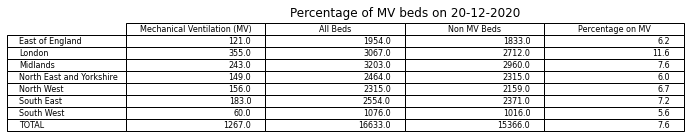

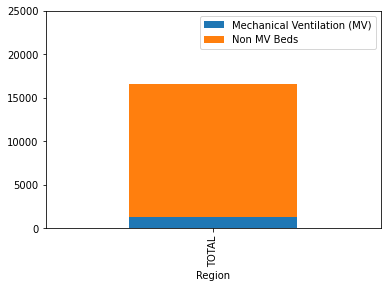

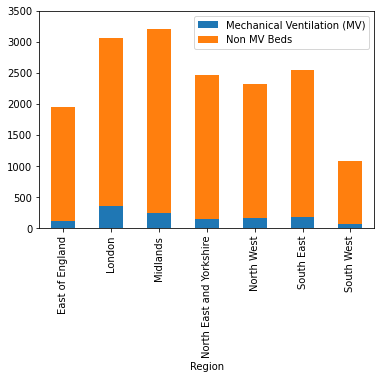

In [16]:
# setting up new dataframe
def mv_vs_all_beds(date_to_compare):
    summary_df = pd.DataFrame()

    # assigning regions and values to summary_df
    summary_df['Region'] = df_MV['Name']
    summary_df['Mechanical Ventilation (MV)'] = df_MV[date_to_compare]
    summary_df['All Beds'] = df_all_beds[date_to_compare]
    summary_df['Non MV Beds'] = summary_df['All Beds'] - summary_df['Mechanical Ventilation (MV)']
    summary_df['Percentage on MV'] =((summary_df['Mechanical Ventilation (MV)'] /summary_df['All Beds']) * 100).round(1)


    # Add title to summary_df
    fig = plt.figure(figsize = (10,2))
    ax = fig.add_subplot(111)
    summary_df = summary_df.set_index(['Region']).reindex(['East of England','London', 'Midlands','North East and Yorkshire',
                                 'North West', 'South East', 'South West','ENGLAND']).reset_index()

    # make Region the index column 12
    summary_df.set_index('Region', inplace=True)

    # Rename last row to 'TOTAL'
    summary_df = summary_df.rename(index={'ENGLAND':"TOTAL"})

    # create a table of data for each date chosen
    ax.table(cellText = summary_df.values,
              rowLabels = summary_df.index,
              colLabels = summary_df.columns,
              loc = "center"
             )
    ax.set_title(f"Percentage of MV beds on {date_to_compare}")
    ax.axis("off")
    return summary_df

def make_bar_graph(summary_df):
    # plot bar chart of TOTAL row
    total_df = summary_df.copy()
    total_df.drop(total_df.index[0:7], inplace=True)
    total_df[['Mechanical Ventilation (MV)','Non MV Beds']].plot(kind='bar', stacked=True, ylim=(0,25000))

    # clean up data ready for construction of bar chart
    no_totals = summary_df.copy()
    no_totals.drop('TOTAL', inplace=True)

    # set ylim so scales are the same on multiple graphs
    no_totals[['Mechanical Ventilation (MV)','Non MV Beds']].plot(kind='bar', stacked=True, ylim=(0,3500))

def comparison_dates(no_of_dates):
    for i in range(no_of_dates):
        date_to_compare = input(f"Please enter the {i+1} dates you would like to compare (dd-mm-yyyy)")
        make_bar_graph(mv_vs_all_beds(date_to_compare))

no_of_dates_to_compare = int(input("Please enter the number of dates you'd like to compare: "))
comparison_dates(no_of_dates_to_compare)



### Scatter plot of all beds vs MV beds (offset MV beds from 1 to 7 days later)

In [ ]:
#extract total row from both 'All beds COVID' and 'MV beds COVID'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# initialise variable to hold the smallest RMSE over the 6 days and assume that occurs
# at day 0
smallest_RMSE = 1000
day = 1
xlsx = pd.ExcelFile('%s.xlsx' % current_covid_admissions, engine='openpyxl')


for i in range(1,10):

    all_MV_beds = pd.read_excel(xlsx, 'MV beds COVID')
    all_beds_england = pd.read_excel(xlsx, 'All beds COVID')

    all_MV_beds = all_MV_beds.iloc[14][3+i:-1]
    all_beds_england = all_beds_england.iloc[14][4:-i]


    # need to reset the index here or NaNs will be introduced
    all_beds_vs_MV_beds = pd.concat([
        all_beds_england.reset_index(drop=True),
        all_MV_beds.reset_index(drop=True)],
        axis=1)
    all_beds_vs_MV_beds.columns = ['All Beds','MV Beds']

    # Linear Regression
    X = all_beds_vs_MV_beds.iloc[:,:-1]
    y = all_beds_vs_MV_beds.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    # create an instance of the LinearRegression class
    ln1 = LinearRegression()

    # Train the regression model
    ln1.fit(X_train, y_train)

    # print the coefficients
    print(f"{i} days difference")
    print(f"The intercept: {ln1.intercept_}")
    print(f"The trained coefficient is: {ln1.coef_}")
    print()

    # predicting the test set
    y_pred = ln1.predict(X_test)

    # RSME (with sqaured=False)
    RMSE = metrics.mean_squared_error(y_pred, y_test, squared=False)
    print(f"RMSE = {RMSE}")
    if RMSE < smallest_RMSE:
        smallest_RMSE = RMSE
        day = i

    # Visualising the Training set results
    plt.scatter(X_train, y_train, color='green')
    plt.plot(X_train, ln1.predict(X_train), color='yellow')
    plt.title(f"All beds vs MV beds (Training set) for day {i}")
    plt.xlabel('All beds')
    plt.ylabel('MV beds')
    plt.show()

    # Visualising the Test set results
    plt.scatter(X_test, y_test, color='red')

    # don't replace anything here as regression line is based on testing set
    plt.plot(X_train, ln1.predict(X_train), color='pink')
    plt.title(f"All beds vs MV beds (Test set) {i} days difference")
    plt.xlabel('All beds')
    plt.ylabel('MV beds')
    plt.show()



In [ ]:
print(f"The smallest RMSE is {smallest_RMSE.round(1)} from {day} day difference")

### Does the linear regression shows that after 1 day patients move onto a MV bed?

### Multiple Linear Regression
##### Independent variables 'All Beds' and 'Hospital Admissions and Diagnosis'
##### Dependent variable 'MV Beds'